# Exercise 05 Classification II

## Pedagogy

This notebook contains both theoretical explanations and executable cells to execute your code.

When you see the <span style="color:red">**[TBC]**</span> (To Be Completed) sign, it means that you need to perform an action else besides executing the cells of code that already exist. These actions can be:
- Complete the code with proper comments
- Respond to a question
- Write an analysis
- etc.

### Import libraries

In [3]:
# import all libraries used in this notebook here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## Part 1. K-Nearest Neighbors with the [Breast cancer wisconsin (diagnostic) dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset)

Build a binary classifier using KNN algorithm for the [Breast cancer wisconsin (diagnostic) dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset)

### Load dataset

Load this dataset using `sklearn.datasets.load_breast_cancer`, you can find the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer).

In [4]:
# load dataset
feature_df, target_df = datasets.load_breast_cancer(
    return_X_y = True,
    as_frame = True
)

### Train test split

70% as the training dataset and the rest as the testing dataset.

Only keep the first two features as the inputs for the convenience of visualization

Shuffle the entire dataset before spliting.

Guarantee the reproducibility by fixing `random_state` as 0.

In [5]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    feature_df[['mean radius', 'mean texture']].values,
    target_df.values,
    train_size = 0.7,
    shuffle = True,
    random_state = 0
)

feature_df[['mean radius', 'mean texture']].values,

(array([[17.99, 10.38],
        [20.57, 17.77],
        [19.69, 21.25],
        ...,
        [16.6 , 28.08],
        [20.6 , 29.33],
        [ 7.76, 24.54]]),)

### Train the model

We will use `sklearn.neighbors.KNeighborsClassifier` to implement a binary classifier.

However, we need to perform feature scaling at first using `sklearn.preprocessing.StandardScaler`.

We could construct a pipeline to embed these two steps.

In [6]:
# construct the pipeline
clf = Pipeline(
    [
        ('standard scaler', StandardScaler()),
        ('k-nearest neighbors', KNeighborsClassifier(
            n_neighbors = 5, # consider 5 nearest neighbors
            weights = 'uniform', # all nearest neighbors are equally important
            metric = 'minkowski', # use Euclidean distance as the distance metric
        ))
    ]
)

In [7]:
# fit the model
clf.fit(X_train, y_train)

Pipeline(steps=[('standard scaler', StandardScaler()),
                ('k-nearest neighbors', KNeighborsClassifier())])

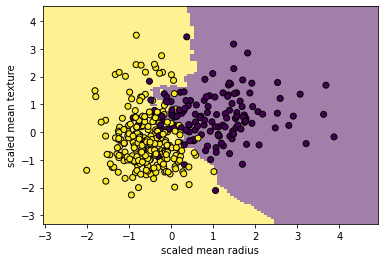

In [8]:
# display the decision boundary learned from the training dataset
# plot decision boundary
disp = DecisionBoundaryDisplay.from_estimator(
    clf['k-nearest neighbors'],
    clf['standard scaler'].transform(X_train),
    response_method = "predict",
    plot_method = "pcolormesh",
    xlabel = 'scaled mean radius'   ,
    ylabel = 'scaled mean texture',
    shading = "auto",
    alpha = 0.5
)
# plot training data points
disp.ax_.scatter(
    clf['standard scaler'].transform(X_train)[:, 0],
    clf['standard scaler'].transform(X_train)[:, 1],
    c = y_train,
    edgecolors = 'k'
)
plt.show()

### Make predictions on testing dataset

In [9]:
# predict categories for testing dataset
y_pred = clf.predict(X_test)
# show the first 5 predictions
y_pred[:5]

array([1, 1, 1, 1, 1])

KNN classifier can also provide a simple estimation of probability.

The estimated probability is simply the fraction of votes among nearest neighbours.

For example, in the 5 nearest neighbors:
- 1 belongs to class 0
- 4 belongs to class 1

Then, the estimated probabilities are:
- The probability of class 0 is 1 / 5 = 0.2
- The probability of class 1 is 4 / 5 = 0.8

In [10]:
# predict probabilities for testing dataset
y_pred_proba = clf.predict_proba(X_test)
# show the first 5 predictions
y_pred_proba[:5, :]

array([[0.4, 0.6],
       [0.4, 0.6],
       [0.2, 0.8],
       [0. , 1. ],
       [0.2, 0.8]])

We can use the methods `KNeighborsClassifier.kneighbors()` to obtain the nearest neighbors of a data point and check if the estimated probabilities is calculated based on the simple fraction of votes.

In [11]:
# obtain nearest neighbors
distances, indices = clf['k-nearest neighbors'].kneighbors(
    clf['standard scaler'].transform(X_test[:5, :])
)
# print the classes of the nearest neighbors
for index in indices:
    print('Classes of nearest neighbors:', y_train[index])

Classes of nearest neighbors: [0 1 0 1 1]
Classes of nearest neighbors: [0 0 1 1 1]
Classes of nearest neighbors: [0 1 1 1 1]
Classes of nearest neighbors: [1 1 1 1 1]
Classes of nearest neighbors: [1 1 0 1 1]


### Evaluate the model

Compute the confusion matrix.

Generate the classification report.

Create the ROC curve and calculate the AUC metric.

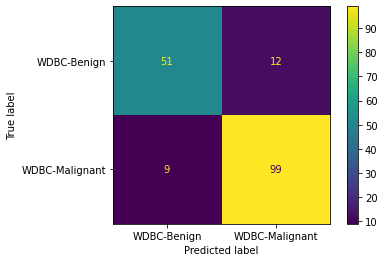

In [12]:
# compute and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels = ['WDBC-Benign', 'WDBC-Malignant']
)
disp.plot()
plt.show()

In [13]:
# get all metrics using `classification_report`
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83        63
           1       0.89      0.92      0.90       108

    accuracy                           0.88       171
   macro avg       0.87      0.86      0.87       171
weighted avg       0.88      0.88      0.88       171



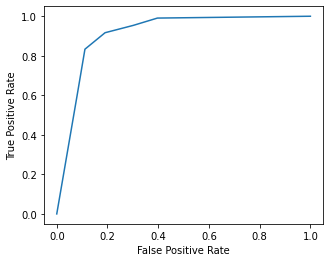

In [14]:
# compute ROC curve
fpr, tpr, thresholds = roc_curve(
    y_test, # the true class
    y_pred_proba[:, 1], # the second column, the probability of being positive
    pos_label = 1 # the positive class is labeled as 1
)

# plot ROC curve
plt.figure(figsize = [5, 4])
plt.plot(fpr, tpr, '-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [15]:
# calculate AUC
auc_test = roc_auc_score(
    y_test, # the true class
    y_pred_proba[:, 1], # the second column, the probability of being positive
)
print("AUC:\t", auc_test)

AUC:	 0.9124779541446209


## Part 2. Support Vector Machine with the [Breast cancer wisconsin (diagnostic) dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset)

Build a binary classifier using SVM algorithm for the [Breast cancer wisconsin (diagnostic) dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset)

### Load dataset

In [16]:
# load dataset
feature_df, target_df = datasets.load_breast_cancer(
    return_X_y = True,
    as_frame = True
)

### Train test split

In [17]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    feature_df[['mean radius', 'mean texture']].values,
    target_df.values,
    train_size = 0.7,
    shuffle = True,
    random_state = 0
)

### Train the model

We will use `sklearn.svm.SVC` to implement a binary classifier.

There are another two different APIs p`rovided by sklearn:
- `sklearn.svm.UnSVC`, similar to `SVC but uses a parameter to control the number of support vectors.
- `sklearn.svm.LinearSVC`, similar to `SVC` with parameter `kernel = 'linear'`

In [18]:
# construct the pipeline
clf = Pipeline(
    [
        ('standard scaler', StandardScaler()),
        ('support vector machine', SVC(
            kernel = 'linear' # linear kernel function
        ))
    ]
)

In [19]:
# fit the model
clf.fit(X_train, y_train)

Pipeline(steps=[('standard scaler', StandardScaler()),
                ('support vector machine', SVC(kernel='linear'))])

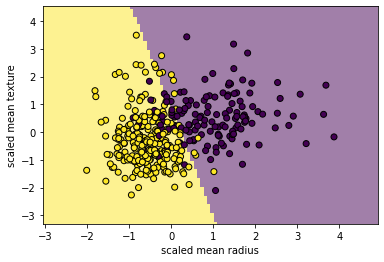

In [20]:
# display the decision boundary learned from the training dataset
# plot decision boundary
disp = DecisionBoundaryDisplay.from_estimator(
    clf['support vector machine'],
    clf['standard scaler'].transform(X_train),
    response_method = "predict",
    plot_method = "pcolormesh",
    xlabel = 'scaled mean radius',
    ylabel = 'scaled mean texture',
    shading = "auto",
    alpha = 0.5
)
# plot training data points
disp.ax_.scatter(
    clf['standard scaler'].transform(X_train)[:, 0],
    clf['standard scaler'].transform(X_train)[:, 1],
    c = y_train,
    edgecolors = 'k'
)
plt.show()

The kernel function is one of the most important parameter for a SVC. We can see how it influence the classifier by showing the decision boundaries.

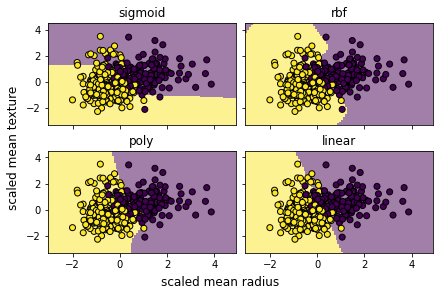

In [21]:
# plot decision boundaries with different kernel functions
fig, axs = plt.subplots(nrows = 2, ncols = 2, layout = 'constrained', sharex = True, sharey = True)
fig.supxlabel('scaled mean radius')
fig.supylabel('scaled mean texture')

for ax, kernel in zip(axs.flatten(), ('sigmoid', 'rbf', 'poly', 'linear')):
    # construct classifier with the specific kernel function
    clf = Pipeline(
        [
            ('standard scaler', StandardScaler()),
            ('support vector machine', SVC(
                kernel = kernel
            ))
        ]
    )
    # train the classifier
    clf.fit(X_train, y_train)
    # plot the decision boundary
    disp = DecisionBoundaryDisplay.from_estimator(
        clf['support vector machine'],
        clf['standard scaler'].transform(X_train),
        response_method = "predict",
        plot_method = "pcolormesh",
        shading = "auto",
        alpha = 0.5,
        ax = ax
    )
    # plot the training data points
    disp.ax_.scatter(
        clf['standard scaler'].transform(X_train)[:, 0],
        clf['standard scaler'].transform(X_train)[:, 1],
        c = y_train,
        edgecolors = 'k'
    )
    # set the title as the kernel function
    disp.ax_.set_title(kernel)

plt.show()

### Make predictions on testing dataset

Let us use the 'linear' kernel as the example for the following prediction and evaluation steps

In [22]:
# construct classifier with the specific kernel function
clf = Pipeline(
    [
        ('standard scaler', StandardScaler()),
        ('support vector machine', SVC(
            kernel = 'linear', # linear kernel function
            probability = True
        ))
    ]
)
# train the classifier
clf.fit(X_train, y_train)

# predict categories for testing dataset
y_pred = clf.predict(X_test)
# show the first 5 predictions
y_pred[:5]

array([1, 1, 1, 1, 1])

A SVM classifier cannot directly predict the probabilities. Although `SVC` provide the `predict_proba` method, the predictions are actually made through the [_Probability Calibration_](https://scikit-learn.org/stable/modules/calibration.html#calibration) process, which involves fitting a logistic regression model with cross validation. And the predicted probabilities may be inconsistent with the predicted classes.

In [23]:
# predict probabilities for testing dataset
y_pred_proba = clf.predict_proba(X_test)
# show the first 5 predictions
y_pred_proba[:5, :]

array([[0.25107186, 0.74892814],
       [0.41924831, 0.58075169],
       [0.18188904, 0.81811096],
       [0.31195226, 0.68804774],
       [0.13693256, 0.86306744]])

### Evaluate the model

Compute the confusion matrix.

Generate the classification report.

Create the ROC curve and calculate the AUC metric.

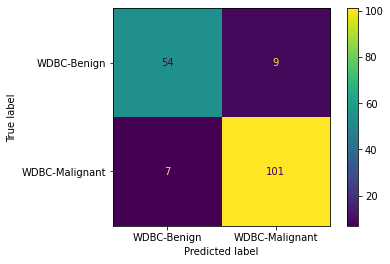

In [24]:
# compute and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels = ['WDBC-Benign', 'WDBC-Malignant']
)
disp.plot()
plt.show()

In [25]:
# get all metrics using `classification_report`
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87        63
           1       0.92      0.94      0.93       108

    accuracy                           0.91       171
   macro avg       0.90      0.90      0.90       171
weighted avg       0.91      0.91      0.91       171



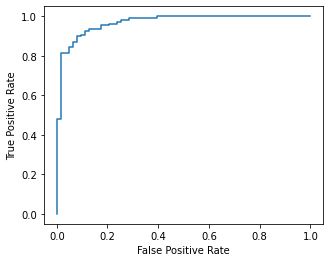

In [26]:
# compute ROC curve
fpr, tpr, thresholds = roc_curve(
    y_test, # the true class
    y_pred_proba[:, 1], # the second column, the probability of being positive
    pos_label = 1 # the positive class is labeled as 1
)

# plot ROC curve
plt.figure(figsize = [5, 4])
plt.plot(fpr, tpr, '-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [27]:
# calculate AUC
auc_test = roc_auc_score(
    y_test, # the true class
    y_pred_proba[:, 1], # the second column, the probability of being positive
)
print("AUC:\t", auc_test)

AUC:	 0.9692827748383304


## Part 2. Hands-on exercise

In this exercise, we will build a multi-class classifier with the the [California Housing dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset), the same one as Exercise 02 & 04.

The goal of the classifier is to perform a multi-class classification taks:
- 0 represents 'Low Price', 'MedHouseVal' < 1
- 1 represents 'Normal Price', 1 <= 'MedHouseVal' <= 2.5
- 2 represents 'Expensive Price', 'MedHouseVal' > 2.5

<span style="color:red">**[TBC]**</span> Please build the classifier with KNN and SVM respectively.

### Task 1. Load the California Housing Dataset

<span style="color:red">**[TBC]**</span> It can be downloaded/loaded using the `sklearn.datasets.fetch_california_housing()` function.

In [28]:
# [TBC] complete your code here with proper comments
from sklearn.datasets import fetch_california_housing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


### Task 2. Create the target labels

<span style="color:red">**[TBC]**</span> Use `MedHouseVal` as the reference to create a pandas series as the new targel variable.

In [29]:
# [TBC] complete your code here with proper comments
feature_df, target_df = fetch_california_housing(
    return_X_y = True, # return features and target separately
    as_frame = True, # return features and target as pandas DataFrame or Series
    # scaled = False # return raw values
)
target_df = pd.DataFrame(target_df, columns=['MedHouseVal'])
target_df['MedHouseVal'] = pd.cut(target_df['MedHouseVal'], bins=[-float('inf'), 1, 2.5, float('inf')], labels=['0', '1','2'])
target_df['MedHouseVal'].head()
label_counts = target_df['MedHouseVal'].value_counts()
print(label_counts.head().sort_values(ascending=True))

0     3658
2     5782
1    11200
Name: MedHouseVal, dtype: int64


### Task 3. Split the dataset into the training and testing part
<span style="color:red">**[TBC]**</span> Please split the whold dataset into two parts: the training and testing set. Please use 70% of the data as the training dataset, and the rest as the testing dataset.

In [30]:
# [TBC] complete your code here with proper comments
X_train, X_test, y_train, y_test = train_test_split(
    feature_df.values,
    target_df.values,
    train_size = 0.7,
    shuffle = True,
    random_state = 0
)

### Task 4. Train and evaluate the multi-class classifier using KNN
<span style="color:red">**[TBC]**</span> Using KNN to build a multi-class classifier, train the model and evaluate the performance using confusion matrix and `classification_report`.

c:\Users\CristianMedina\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Classes of nearest neighbors: [['1']
 ['1']
 ['1']
 ['1']
 ['1']]
Classes of nearest neighbors: [['2']
 ['1']
 ['2']
 ['1']
 ['1']]
Classes of nearest neighbors: [['1']
 ['1']
 ['0']
 ['1']
 ['1']]
Classes of nearest neighbors: [['0']
 ['0']
 ['0']
 ['0']
 ['0']]
Classes of nearest neighbors: [['2']
 ['2']
 ['2']
 ['2']
 ['1']]
              precision    recall  f1-score   support

           0       0.79      0.68      0.73      1098
           1       0.76      0.85      0.80      3352
           2       0.79      0.68      0.73      1743

    accuracy                           0.77      6193
   macro avg       0.78      0.74      0.76      6193
weighted avg       0.77      0.77      0.77      6193



<Figure size 720x576 with 0 Axes>

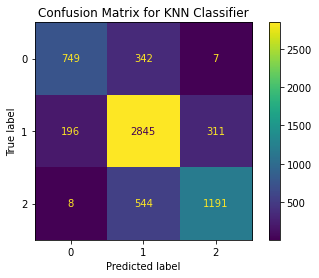

In [31]:
clf = Pipeline(
    [
        ('standard scaler', StandardScaler()),
        ('k-nearest neighbors', KNeighborsClassifier(
            n_neighbors = 5, # consider 5 nearest neighbors
            weights = 'uniform', # all nearest neighbors are equally important
            metric = 'minkowski', # use Euclidean distance as the distance metric
        ))
    ]
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

#nearest neighbors
distances, indices = clf['k-nearest neighbors'].kneighbors(
    clf['standard scaler'].transform(X_test[:5, :])
)
# print the classes of the nearest neighbors
for index in indices:
    print('Classes of nearest neighbors:', y_train[index])
    
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2]).plot(values_format='d')
plt.title('Confusion Matrix for KNN Classifier')
plt.show()

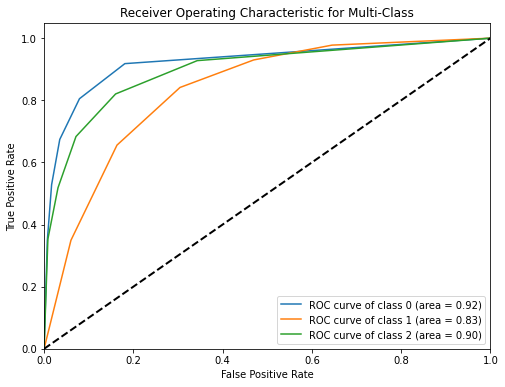

In [32]:
fpr, tpr, roc_auc = {}, {}, {}
n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_proba[:,i], pos_label=str(i))
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--', lw = 2)  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()



### Task 5. Train and evaluate the multi-class classifier using SVM
<span style="color:red">**[TBC]**</span> Using SVM to build a multi-class classifier, train the model and evaluate the performance using confusion matrix and `classification_report`.

c:\Users\CristianMedina\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.73      0.59      0.65      1098
           1       0.75      0.85      0.80      3352
           2       0.81      0.69      0.75      1743

    accuracy                           0.76      6193
   macro avg       0.76      0.71      0.73      6193
weighted avg       0.76      0.76      0.76      6193



<Figure size 720x576 with 0 Axes>

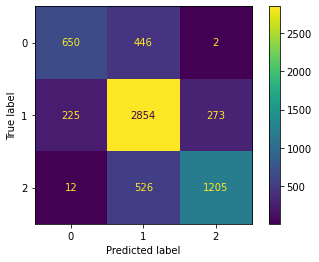

In [33]:
# [TBC] complete your code here with proper comments

clf = Pipeline(
    [
        ('standard scaler', StandardScaler()),
        ('support vector machine', SVC(
            kernel = 'linear', # linear kernel function
            probability = True
        ))
    ]
)
# train the classifier
clf.fit(X_train, y_train)

# predict categories for testing dataset
y_pred = clf.predict(X_test)
# show the first 5 predictions
y_pred[:5]

y_pred_proba = clf.predict_proba(X_test)
# show the first 5 predictions
y_pred_proba[:5, :]

cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2]).plot(values_format='d')
# plt.title('Confusion Matrix for KNN Classifier')
plt.show()



### Challenge. Improve the performance of the above classifier

Try to improve the performance of the above classifiers by adding feature selection process and changing parameter values.

<span style="color:red">**[TBC]**</span> This challenge won't be evaluated and counted towards your grade. You may submit this assignment without solving this challenge. However, leaving this part blank is not allowed. Try to complete the code even if it doesn't meet the requirements.

## KNN IMPROVED PERFORMANCE


0     3658
2     5782
1    11200
Name: MedHouseVal, dtype: int64


c:\Users\CristianMedina\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\CristianMedina\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


              precision    recall  f1-score   support

           0       0.69      0.58      0.63      1098
           1       0.70      0.80      0.75      3352
           2       0.72      0.60      0.65      1743

    accuracy                           0.70      6193
   macro avg       0.70      0.66      0.68      6193
weighted avg       0.70      0.70      0.70      6193



<Figure size 720x576 with 0 Axes>

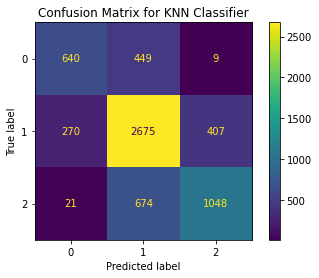

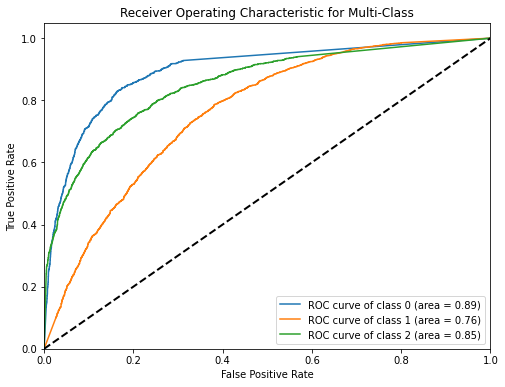

In [18]:
# Define the pipeline

from sklearn.datasets import fetch_california_housing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif

# [TBC] complete your code here with proper comments
feature_df, target_df = fetch_california_housing(
    return_X_y = True, # return features and target separately
    as_frame = True, # return features and target as pandas DataFrame or Series
    # scaled = False # return raw values
)
target_df = pd.DataFrame(target_df, columns=['MedHouseVal'])
target_df['MedHouseVal'] = pd.cut(target_df['MedHouseVal'], bins=[-float('inf'), 1, 2.5, float('inf')], labels=['0', '1','2'])
target_df['MedHouseVal'].head()
label_counts = target_df['MedHouseVal'].value_counts()
print(label_counts.head().sort_values(ascending=True))

# [TBC] complete your code here with proper comments
X_train, X_test, y_train, y_test = train_test_split(
    feature_df.values,
    target_df.values,
    train_size = 0.7,
    shuffle = True,
    random_state = 0
)

clf = Pipeline([
    ('standard scaler', StandardScaler()),
    ('select best', SelectKBest(score_func=f_classif, k=3)),  # Adjust 'k' as needed
    ('k-nearest neighbors', KNeighborsClassifier(
        n_neighbors=9,  # consider 5 nearest neighbors
        weights='distance',  # all nearest neighbors are equally important
        metric='minkowski',  # use Euclidean distance as the distance metric
    ))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

    
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2]).plot(values_format='d')
plt.title('Confusion Matrix for KNN Classifier')
plt.show()

fpr, tpr, roc_auc = {}, {}, {}
n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_proba[:,i], pos_label=str(i))
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--', lw = 2)  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()

## VECTOR IMPROVED PERFORMANCE


c:\Users\CristianMedina\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\CristianMedina\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.68      0.43      0.53      1098
           1       0.67      0.86      0.75      3352
           2       0.78      0.51      0.62      1743

    accuracy                           0.69      6193
   macro avg       0.71      0.60      0.63      6193
weighted avg       0.70      0.69      0.67      6193



<Figure size 720x576 with 0 Axes>

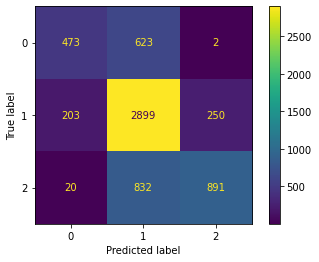

In [19]:
# [TBC] complete your code here with proper comments

clf = Pipeline(
    [
        ('standard scaler', StandardScaler()),
        ('select best', SelectKBest(score_func=f_classif, k=3)),
        ('support vector machine', SVC(
            kernel = 'linear', # linear kernel function
            probability = True
        ))
    ]
)
# train the classifier
clf.fit(X_train, y_train)

# predict categories for testing dataset
y_pred = clf.predict(X_test)
# show the first 5 predictions
y_pred[:5]

y_pred_proba = clf.predict_proba(X_test)
# show the first 5 predictions
y_pred_proba[:5, :]

cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2]).plot(values_format='d')
# plt.title('Confusion Matrix for KNN Classifier')